# Representation Learning
대표성 학습

## 사진 적게 해서 해보기

In [1]:
%%capture
!pip install facenet-pytorch faiss-cpu datasets

In [25]:
%%capture
!wget -O wonbin.jpg https://images.chosun.com/resizer/EHf4wnSIY9IV5HxZWjNiuHN5q6Q=/500x686/smart/cloudfront-ap-northeast-1.images.arcpublishing.com/chosun/OPHIMALOFGWHFL2JY2G4QBKHXU.jpg
!wget -O wonbin2.jpg https://www.themoviedb.org/t/p/w500/7Ginzkr5lRT7x3bGc3GFSONNT7N.jpg
!wget -O sojiseop.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/So_Ji-sub.jpg/250px-So_Ji-sub.jpg
!wget -O biden.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Joe_Biden_presidential_portrait.jpg/300px-Joe_Biden_presidential_portrait.jpg
!wget -O timberlake.jpg https://cdn.britannica.com/07/173707-050-6C97735C/Justin-Timberlake.jpg?w=400&h=300&c=crop

In [3]:
import torch

torch.set_grad_enabled(False)

In [4]:
%%capture
from facenet_pytorch import MTCNN, InceptionResnetV1

mtcnn = MTCNN(image_size=160, margin=0).eval()
resnet = InceptionResnetV1(pretrained='vggface2').cuda().eval()

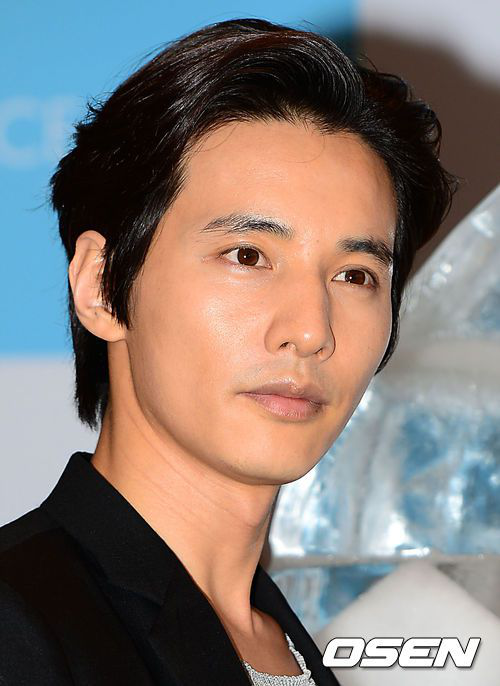

torch.Size([3, 160, 160])

In [5]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image, to_tensor

image = Image.open('wonbin.jpg')
display(image)
image_cropped = mtcnn(image)
image_cropped.shape

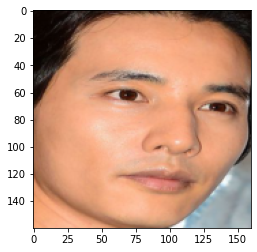

In [6]:
import matplotlib.pyplot as plt

plt.imshow(((image_cropped + 1) / 2).permute(1, 2, 0))
plt.show()

In [7]:
embeds = resnet(image_cropped.unsqueeze(0).cuda())
embeds.shape

torch.Size([1, 512])

In [8]:
def get_face_embedding(filename):
  image = Image.open(filename)
  image_cropped = mtcnn(image)
  embeds = resnet(image_cropped.unsqueeze(0).cuda())
  return embeds.squeeze(0)

wonbin1 = get_face_embedding("wonbin.jpg")
wonbin2 = get_face_embedding("wonbin2.jpg")
sojiseop = get_face_embedding("sojiseop.jpg")

In [9]:
import torch

@torch.no_grad()
def cos_sim(a, b):
  return torch.dot(a, b)

cos_sim(wonbin1, wonbin2), cos_sim(wonbin1, sojiseop),

(tensor(0.7679, device='cuda:0'), tensor(0.2282, device='cuda:0'))

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
#stalin = get_face_embedding("stalin01.jpg")
#stalin_lookalike = get_face_embedding("stalin_lookalike.jpg")
#hitler = get_face_embedding("hitler.jpg")

In [13]:
#cos_sim(stalin, stalin_lookalike), cos_sim(stalin, hitler),

## 더 큰 데이터셋 사용

In [ ]:
%%capture
!unzip /content/drive/MyDrive/2022Python소수전공/자료/celeba-img-align-ids-1k.zip -d faces

In [ ]:
%%capture
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="faces/", split="train")
dataset

In [16]:
%%capture
import faiss

index = faiss.IndexFlatIP(512)

In [ ]:
%%capture
from tqdm.auto import tqdm

for item in tqdm(dataset):
  image = item['image']
  image = image.crop((9, 29, 169, 189))
  emb = resnet(to_tensor(image).unsqueeze(0).cuda()).cpu().numpy()
  faiss.normalize_L2(emb)
  index.add(emb)

In [29]:
%%capture
import numpy as np

def search(filename, k=10):
  face = get_face_embedding(filename)
  face = np.expand_dims(face.cpu().numpy(), 0)
  dists, indices = index.search(face, k)
  for d, i in zip(dists[0], indices[0]):
    target = dataset[i.item()]
    display(target['image'])
    print(f"검색 결과: {target['label']} 점수: {d}")

In [ ]:
search("wonbin2.jpg")